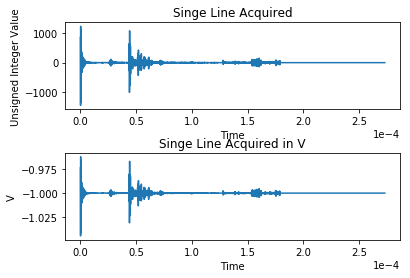

In [1]:
%matplotlib inline

#now we import different packages that will allow to do math, lineal algebra, numerical operations, array operations and plotting
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from scipy.signal import hilbert

#we use a simple open command for the file (basic Python)
f = open('LabRFdata.bin','rb')   # Windows
#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
Line = np.fromfile(f,count=-1,dtype=np.int16)
L=4096 #number of samples
f.close() #close the file
#we will now populate an array for the time which we now is 1/125MHz step for a total of 15000
x=np.arange(0,L/15e6,1/15e6)  #start,stop,step
#now we plot only the first line acquired (15000 samples)
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(x,Line[:L])
plt.title('Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#But this is in integers, in volts we need to calculate 2Vpp -> 65535=1V and 0=-1V
LineF=Line.astype(np.float64)
LineF/=(2**15-1)
LineF-=1.
plt.subplot(212)
plt.plot(x,LineF[:L])
plt.title('Singe Line Acquired in V')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

The total lines are:128.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Length (mm)')

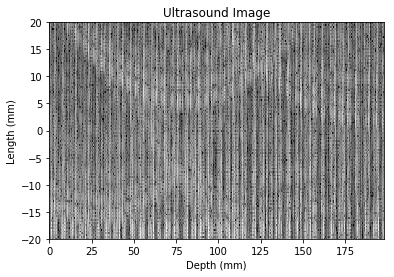

In [2]:
TL=len(Line)/L
print('The total lines are:'+str(TL))
Line=Line-np.mean(Line)
LineF=Line.reshape(int(TL),L,order='F').copy()#Compensating
fc=4e6
Attenuation=0.0022
h=x*1450
ffatt=np.exp(Attenuation*fc/1e6*h)
LineC=LineF*ffatt
LineE=hilbert(LineC)
LinesRFE=abs(LineE)

LinesRFE=abs(LinesRFE)

#images need to be logarithmic so we can see all the contrast
Mx=LinesRFE.max()
Image=20*np.log10(LinesRFE/Mx)
ImageBW=LinesRFE
#images need to be logarithmic so we can see all the contrast
Mx=LinesRFE.max()
Image=20*np.log10(LinesRFE/Mx)
ImageBW=LinesRFE

#the line axis
s=np.linspace(-20,20,int(TL))
#Plotting
d=h/2*1000  #answer: why are we doing this here?
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, Image[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(3.2/1) # 
plt.title('Ultrasound Image')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Length (mm)')

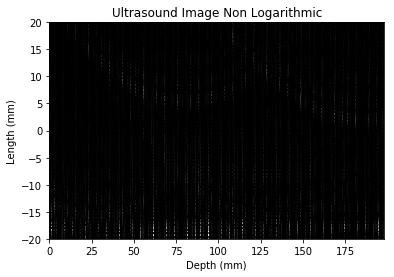

In [3]:
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageBW[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(3.2/1)
plt.title('Ultrasound Image Non Logarithmic')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


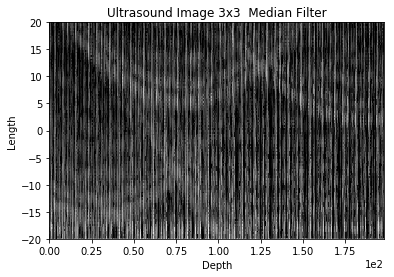

In [4]:
from scipy.signal import medfilt

#we cut anything below -60dB
cutdb=-60
inx=np.where(Image<cutdb)
Image[inx]=cutdb

#and we filter using a 7x7 median filter
ImageF=medfilt(Image,3)

#Plotting
d=h/2*1000
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageF[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(3.2/1)
plt.title('Ultrasound Image 3x3  Median Filter')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


The Index number at max frequency is  398976
The frequency is 468750.0


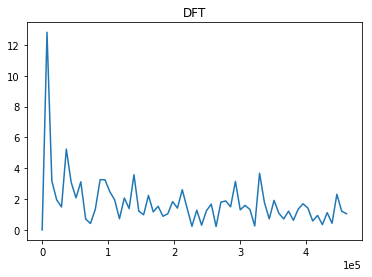

In [52]:
#Eliminating dc
Line-=np.mean(Line)
#Now let's obtain the spectrum
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,15e6/2,15e6/L)
Y=np.fft.fft(Line)
Pyy=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
#preparing the plotting
plt.subplots_adjust( wspace = 1.5 )
plt.subplot(111)
L2=len(Pyy)/2
plt.plot(f[:64], Pyy[:64])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
y=np.argmax(Pyy)
print ("The Index number at max frequency is  " + str(y))
print("The frequency is " + str(f[64]))

Ans2: the Ultrasound frequency is 4.68 MHz.

[0, 119, 0, 127]

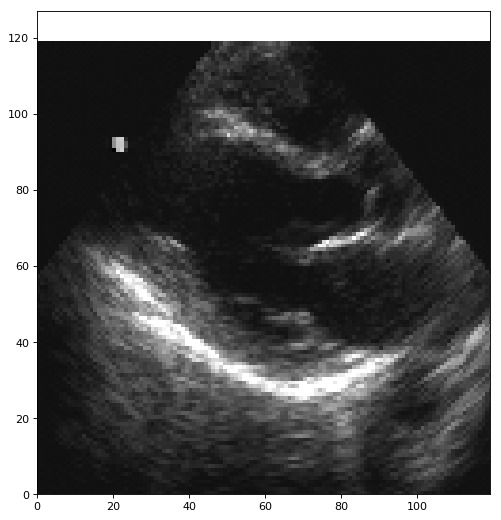

In [55]:
%matplotlib inline
from skimage import novice, data, io, exposure
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import dicom

#it is possible that in some installations pyDICOM won't be available in which case you will have to install it through pip

# Get file
RefDs = dicom.read_file('US-MONO2-8-8x-execho.dcm')
ConstPixelDims = (int(RefDs.NumberofFrames),int(RefDs.Rows), int(RefDs.Columns))
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
ds = dicom.read_file('US-MONO2-8-8x-execho.dcm')
ArrayDicom[:,:,:]=ds.pixel_array

#plt.figure()
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
x=np.arange(RefDs.Rows)
y=np.arange(RefDs.Columns)

plt.pcolormesh(y, x, np.flipud(ArrayDicom[1,:, :]))
plt.axis([x.min(),x.max(),y.min(),y.max()])